201920915 박영빈 인공지능기초 중간고사 대체과제 컴퓨터 비전

Fashion mnist 60000개의 훈련 데이터를 두개의 컨볼루션 레이어와 두개의 폴링 레이어가 있는 CNN 모델을 만들어 학습을 시켰습니다.
Fashion mnist 10000개의 테스트 데이터로 훈련시킨 모델의 각 클래스별 정확도를 계산하고 결과에 대한 해석을 해보았습니다.

에포크 수 = 5   
배치 사이즈 = 100   
러닝 레이트 = 0.001 

In [8]:
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv

from pytorchcv import load_mnist, plot_results

# pytorchcv.py에 있는 load_mnist 함수를 실행해 fashion mnist 데이터를 로드 배치 사이즈는 100
load_mnist(batch_size=100)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
#load_mnist() 실행 결과 확인

#데이터 사이즈 확인
print("train_data size:", len(train_data))
print("test_data size:", len(test_data))

#배치 크기 100, 1개의 채널(greyscale), 세로 28, 가로 28
img, lbl = next(iter(train_loader))
print(img.shape, lbl.shape)
print("배치 사이즈 100, greyscale 28 by 28 이미지")

train_data size: 60000
test_data size: 10000
torch.Size([100, 1, 28, 28]) torch.Size([100])
배치 사이즈 100, greyscale 28 by 28 이미지


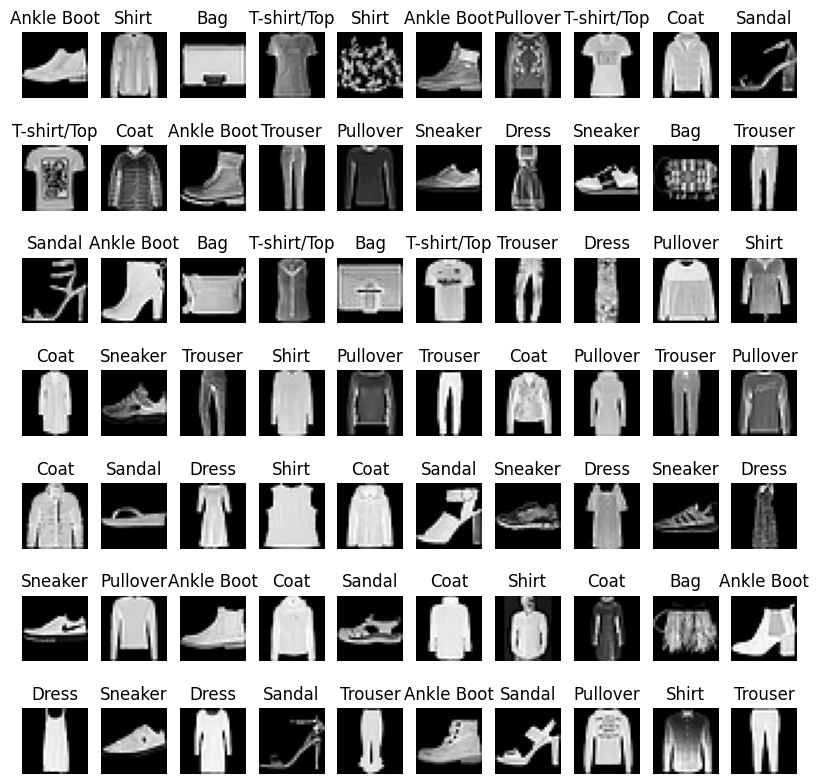

In [10]:
# Fashion MNIST 데이터 랜덤으로 일부 확인

# 숫자인 라벨을 보기쉽게 매칭하기 위해
def output_label(label):
    output_mapping = { 
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot" 
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

figure = plt.figure(figsize=(10, 10))
cols, rows = 10, 7

# 랜덤으로 이미지를 선택해서 출력 matplotlib 모듈을 통해 출력
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(output_label(label))
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

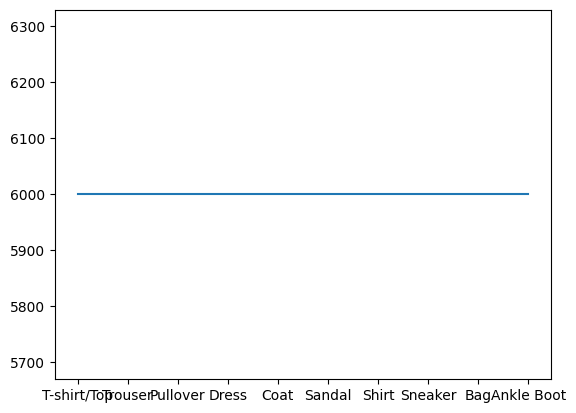

In [11]:
# 각 클래스별 데이터 수 확인 모두 균일하게 6000개씩의 데이터가 10개의 클래스에 있다

x = [output_label(i) for i in range(10)]
y = [0 for i in range(10)]

for i in train_data.targets:
    y[i] += 1

plt.plot(x, y)
plt.show()

In [12]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정

import torch.nn as nn # 파이토치의 신경망 모듈 nn을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트

class CNN(nn.Module): # nn.Module을 상속받는 CNN라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self):
        super(CNN, self).__init__() # 부모클래스 초기화를 통해 적절히 초기화
        
        # 첫 번쨰 레이어
        # 컨볼루션: 인풋 채널은 1개, 아웃풋 채널은 32개, 커널사이즈는 3 by 3, 패딩 1. 필터수는 32개(1 -> 32 32배이므로) 32개의 필터가 각각 합성곱을 통해 특징을 추출해 피쳐맵 출력
        # 배치 정규화와 Relu 활성화 함수 max(x, 0)를 거치고 가장 강한 특징만 남기고 다운 스케일을 해주기 위해 Max Pooling 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 두 번쨰 레이어
        # 컨볼루션: 인풋 채널은 32개, 아웃풋 채널은 64개, 커널사이즈는 3 by 3. 필터수는 2개(32 -> 64 두배이므로) 2개의 필터가 각각 합성곱을 통해 특징을 추출해 피쳐맵 출력
        # 배치 정규화와 Relu 활성화 함수 max(x, 0)를 거치고 가장 강한 특징만 남기고 다운 스케일을 해주기 위해 Max Pooling 
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # fcn 레이어 다차원의 피쳐맵을 한줄의 백터로 마지막에는 10개의 값 출력(10개의 클래스)
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
        # 각 단계 를 거치고 out을 리턴
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

net = CNN() # CNN 클래스의 인스턴스를 생성

# 만든 모델의 요약 파라미터 개수랑 용량 확인
summary(net, input_size=(1, 28, 28), batch_size=100) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비), 배치 사이즈는 100

# 모델 확인
print(net)

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 32, 28, 28]             320
       BatchNorm2d-2          [100, 32, 28, 28]              64
              ReLU-3          [100, 32, 28, 28]               0
         MaxPool2d-4          [100, 32, 14, 14]               0
            Conv2d-5          [100, 64, 12, 12]          18,496
       BatchNorm2d-6          [100, 64, 12, 12]             128
              ReLU-7          [100, 64, 12, 12]               0
         MaxPool2d-8            [100, 64, 6, 6]               0
            Linear-9                 [100, 600]       1,383,000
        Dropout2d-10                 [100, 600]               0
           Linear-11                 [100, 120]          72,120
           Linear-12                  [100, 10]           1,210
Total params: 1,475,338
Trainable par

In [13]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

# 클래스별 정확성을 알기 위한 목록
predictions_list = []
labels_list = []

def train(model, train_loader, test_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    labels_list.append(target) # 정답 라벨 기록
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    predictions_list.append(predicted) # 예측 라벨 기록
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환



Epoch 1/5: Train Loss: 0.0042, Train Acc: 84.93%, Test Loss: 0.0032, Test Acc: 88.85%
Epoch 2/5: Train Loss: 0.0029, Train Acc: 89.44%, Test Loss: 0.0040, Test Acc: 86.06%
Epoch 3/5: Train Loss: 0.0025, Train Acc: 90.92%, Test Loss: 0.0036, Test Acc: 87.44%
Epoch 4/5: Train Loss: 0.0023, Train Acc: 91.71%, Test Loss: 0.0034, Test Acc: 88.42%
Epoch 5/5: Train Loss: 0.0021, Train Acc: 92.36%, Test Loss: 0.0032, Test Acc: 89.05%


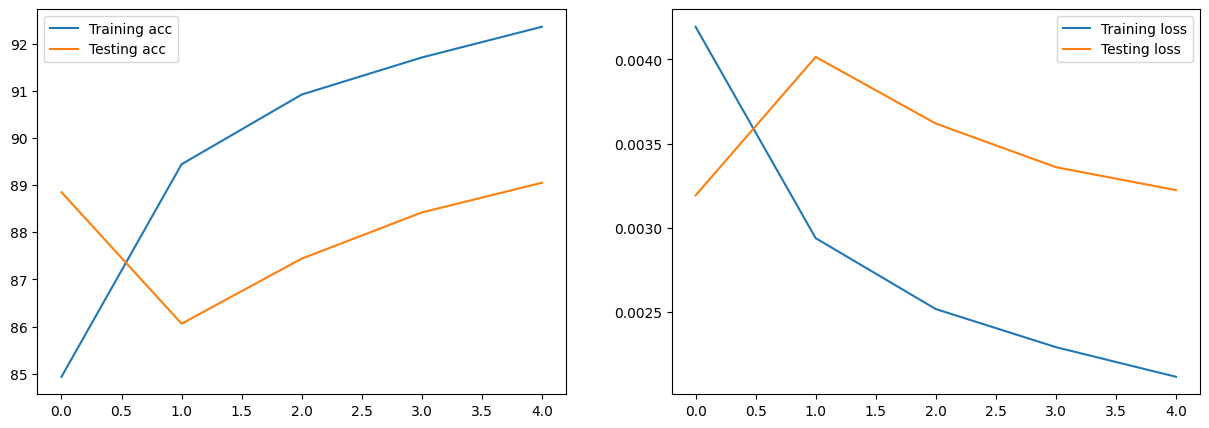

In [14]:
# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정

# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(net, train_loader, test_loader, epochs=5)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할
    
else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌

In [17]:
# 훈련 시킨 모델의 테스트 데이터에 대한 정확성을 각 클래스 마다 출력

from torch.autograd import Variable # Variable은 tensor와 같은 형식 데이터 타입

class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 훈련 시킨 모델에 테스트 데이터를 돌려 각 클래스별 정확도 확인
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = net(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

# 각 클래스 별 정확도 출력
# T-shirt와 Shirt, Pullover는 상대적으로 서로 비슷해 구분이 힘들어 정확도가 낮다고 생각됨      
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

/home/codespace/.python/current/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of T-shirt/Top: 82.20%
Accuracy of Trouser: 98.70%
Accuracy of Pullover: 57.50%
Accuracy of Dress: 92.70%
Accuracy of Coat: 90.70%
Accuracy of Sandal: 98.10%
Accuracy of Shirt: 80.10%
Accuracy of Sneaker: 97.40%
Accuracy of Bag: 97.60%
Accuracy of Ankle Boot: 95.50%


In [18]:
from itertools import chain # 리스트를 붙여주는 함수

# 위에서 저장해 두었던 테스트 데이터에 대한 예측과 라벨을 이용 
predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

import sklearn.metrics as metrics # 행렬
from sklearn.metrics import confusion_matrix # 모델의 어디에서 오류가 발생했는지 평가하기 위해 분류 문제에서 사용되는 테이블인 혼동 행렬을 구해주는 함수

# precision: 모델이 예측한 것 중 예측이 맞은 비율
# recall: 해당 클래스 전체 데이터 중 예측이 맞은 비율
# f1 score: 위 둘의 조화 평균
# 각 클래스별 지표를 확인 할 수 있다
confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n" %(metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      5000
           1       1.00      0.97      0.98      5000
           2       0.93      0.58      0.71      5000
           3       0.86      0.94      0.90      5000
           4       0.70      0.91      0.79      5000
           5       0.98      0.96      0.97      5000
           6       0.68      0.73      0.70      5000
           7       0.93      0.98      0.95      5000
           8       0.98      0.98      0.98      5000
           9       0.97      0.95      0.96      5000

    accuracy                           0.88     50000
   macro avg       0.89      0.88      0.88     50000
weighted avg       0.89      0.88      0.88     50000




에포크 수나 배치 사이즈 러닝 레이트를 변경하며 다른 조건에서 몇번을 테스트 하였습니다.  
다른 클래스에 비해 상대적으로 계속 해서 낮은 정확도를 보이는 클래스는 T-shirt와 Shirt, Pullover로 서로 비슷하여 구분이 잘 이루어 지지 않는다고 생각됩니다.